In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud

In [2]:
pd.set_option('display.max_columns', None)


DATA_PATH = "ai_job_dataset.csv"


df = pd.read_csv(DATA_PATH, low_memory=False)

print("Loaded dataset with shape:", df.shape)
df.head()

Loaded dataset with shape: (15000, 19)


,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,USD,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,AI Software Engineer,61895,USD,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,USD,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech
3,AI00004,NLP Engineer,80215,USD,SE,FL,India,M,India,50,"Scala, SQL, Linux, Python",PhD,7,Consulting,2024-12-23,2025-02-24,1345,8.6,Future Systems
4,AI00005,AI Consultant,54624,EUR,EN,PT,France,S,Singapore,100,"MLOps, Java, Tableau, Python",Master,0,Media,2025-04-15,2025-06-23,1989,6.6,Advanced Robotics


In [3]:

print('Columns:', df.columns.tolist())
print("\nMissing values by column:")
print(df.isnull().sum().sort_values(ascending=False).head(20))
df.info()


Columns: ['job_id', 'job_title', 'salary_usd', 'salary_currency', 'experience_level', 'employment_type', 'company_location', 'company_size', 'employee_residence', 'remote_ratio', 'required_skills', 'education_required', 'years_experience', 'industry', 'posting_date', 'application_deadline', 'job_description_length', 'benefits_score', 'company_name']

Missing values by column:
job_id                    0
job_title                 0
salary_usd                0
salary_currency           0
experience_level          0
employment_type           0
company_location          0
company_size              0
employee_residence        0
remote_ratio              0
required_skills           0
education_required        0
years_experience          0
industry                  0
posting_date              0
application_deadline      0
job_description_length    0
benefits_score            0
company_name              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999


In [4]:

df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

if "salary_usd" in df.columns and pd.api.types.is_numeric_dtype(df["salary_usd"]):
    print("Using salary_usd column for salary analysis.")
else:
    print("salary_usd not found, trying to parse salary_range...")
    if "salary_range" in df.columns:
        def parse_range(x):
            try:
                if pd.isna(x): return np.nan
                x = str(x).replace(",", "").replace("$", "")
                nums = re.findall(r"\d+", x)
                if len(nums) >= 2:
                    low, high = float(nums[0]), float(nums[1])
                    if low < 1000: low *= 1000
                    if high < 1000: high *= 1000
                    return (low + high) / 2
            except:
                return np.nan
            return np.nan
        df["salary_usd"] = df["salary_range"].apply(parse_range)
    else:
        df["salary_usd"] = np.nan

print("\nSalary stats:")
print(df["salary_usd"].describe())


Using salary_usd column for salary analysis.

Salary stats:
count     15000.000000
mean     115348.965133
std       60260.940438
min       32519.000000
25%       70179.750000
50%       99705.000000
75%      146408.500000
max      399095.000000
Name: salary_usd, dtype: float64


In [5]:

print("\nTop 10 Job Titles:")
print(df["job_title"].value_counts().head(10))

print("\nTop 10 Companies:")
print(df["company_name"].value_counts().head(10))

print("\nTop 10 Locations:")
if "company_location" in df.columns:
    print(df["company_location"].value_counts().head(10))
elif "location" in df.columns:
    print(df["location"].value_counts().head(10))



Top 10 Job Titles:
job_title
Machine Learning Researcher    808
AI Software Engineer           784
Autonomous Systems Engineer    777
Machine Learning Engineer      772
AI Architect                   771
Head of AI                     765
NLP Engineer                   762
Robotics Engineer              759
Data Analyst                   759
AI Research Scientist          756
Name: count, dtype: int64

Top 10 Companies:
company_name
TechCorp Inc                  980
Cognitive Computing           972
AI Innovations                964
Digital Transformation LLC    961
Quantum Computing Inc         960
Future Systems                960
Cloud AI Solutions            951
Predictive Systems            947
Smart Analytics               927
Advanced Robotics             925
Name: count, dtype: int64

Top 10 Locations:
company_location
Germany      814
Denmark      778
Canada       769
France       769
Austria      765
Singapore    764
China        763
India        754
Sweden       752
Israel 

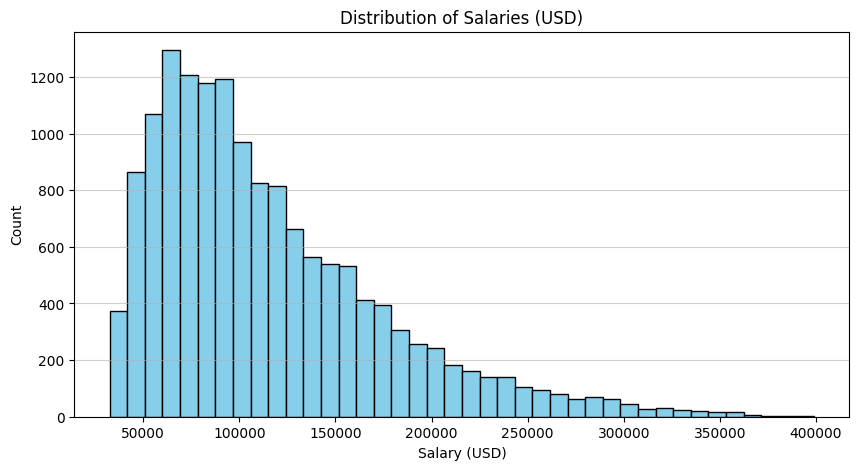

/tmp/ipython-input-3511534763.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=levels, showfliers=False)


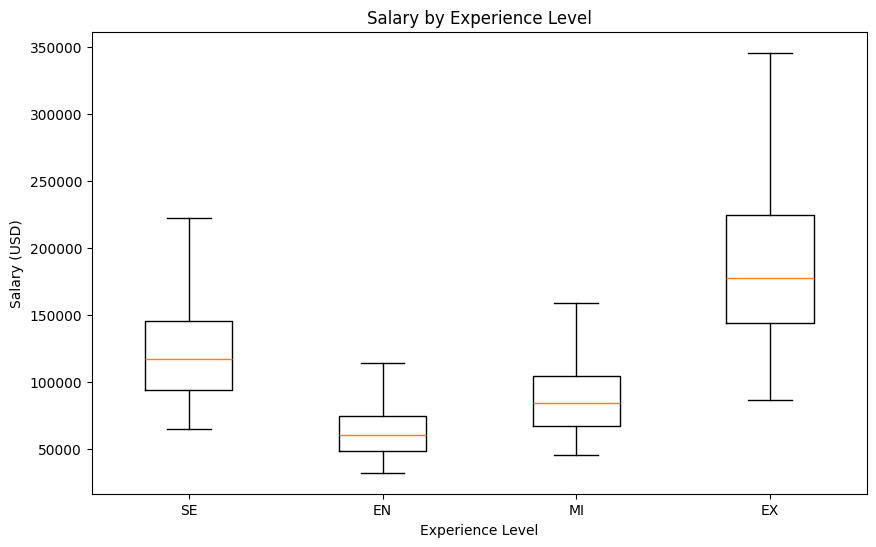

In [6]:

plt.figure(figsize=(10,5))
salaries = df["salary_usd"].dropna()
plt.hist(salaries, bins=40, color="skyblue", edgecolor="black")
plt.title("Distribution of Salaries (USD)")
plt.xlabel("Salary (USD)")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.6)
plt.show()


if "experience_level" in df.columns:
    groups = df[["experience_level","salary_usd"]].dropna()
    levels = groups["experience_level"].unique()
    data_to_plot = [groups.loc[groups["experience_level"]==lvl,"salary_usd"] for lvl in levels]
    plt.figure(figsize=(10,6))
    plt.boxplot(data_to_plot, labels=levels, showfliers=False)
    plt.title("Salary by Experience Level")
    plt.xlabel("Experience Level")
    plt.ylabel("Salary (USD)")
    plt.show()


Skills column detected: required_skills

Top 20 Skills:
required_skills
A    41150
T    34439
S    30565
E    29190
O    28973
I    24512
N    24263
L    23037
P    23025
R    21753
C    15935
U    14753
H    11589
D     8740
M     8334
G     7262
Y     7227
V     7132
K     7026
B     5350
Name: count, dtype: int64


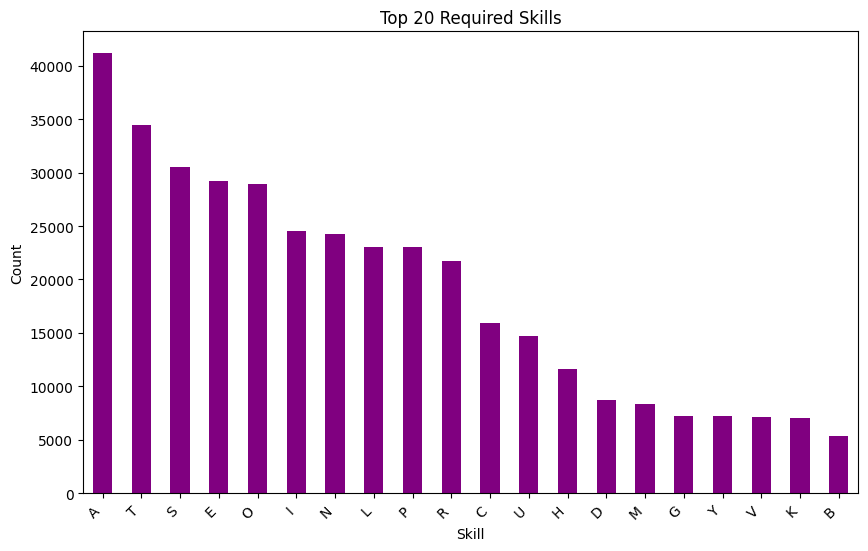

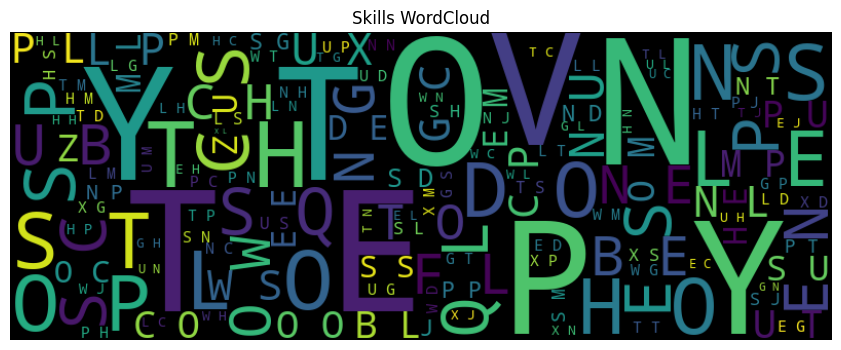

In [7]:

skills_col = None
for c in ["required_skills","skills","required_skills_list"]:
    if c in df.columns:
        skills_col = c
        break

if skills_col:
    print("Skills column detected:", skills_col)
    skills_series = df[skills_col].dropna().astype(str).apply(
        lambda x: [s.strip() for s in re.split(r",|;|/|\\|", x) if s.strip()]
    )
    skills_exploded = skills_series.explode().str.title().str.replace("\\s+", " ", regex=True)
    top_skills = skills_exploded.value_counts().head(20)

    print("\nTop 20 Skills:")
    print(top_skills)

    # Bar Chart
    plt.figure(figsize=(10,6))
    top_skills.plot(kind="bar", color="purple")
    plt.title("Top 20 Required Skills")
    plt.xlabel("Skill")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.show()

    # WordCloud
    wc_text = " ".join(skills_exploded.dropna().tolist())
    wc = WordCloud(width=800, height=300).generate(wc_text)
    plt.figure(figsize=(12,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Skills WordCloud")
    plt.show()
else:
    print("No skills column found.")


/tmp/ipython-input-2109316825.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_series = df.set_index("posting_date").resample("M").size()


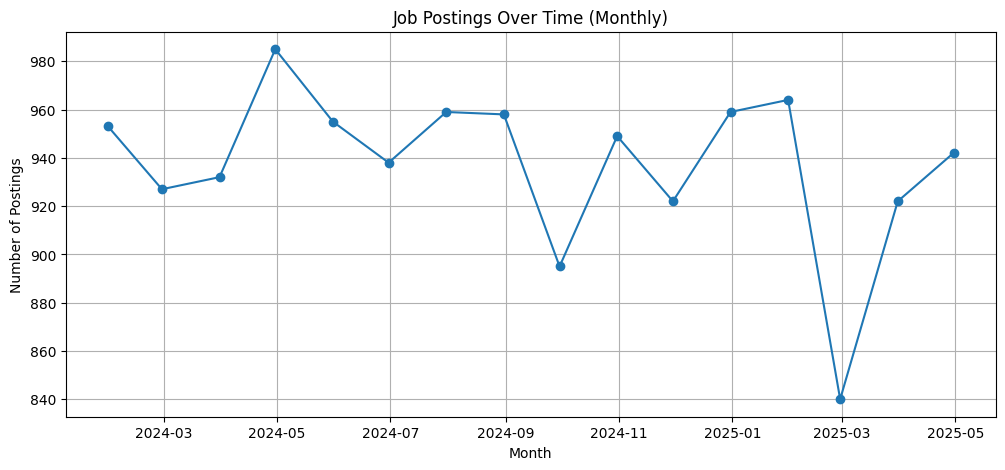

In [8]:

if "posting_date" in df.columns:
    df["posting_date"] = pd.to_datetime(df["posting_date"], errors="coerce")
    time_series = df.set_index("posting_date").resample("M").size()
    plt.figure(figsize=(12,5))
    plt.plot(time_series.index, time_series.values, marker="o")
    plt.title("Job Postings Over Time (Monthly)")
    plt.xlabel("Month")
    plt.ylabel("Number of Postings")
    plt.grid(True)
    plt.show()
else:
    print("posting_date column not found.")


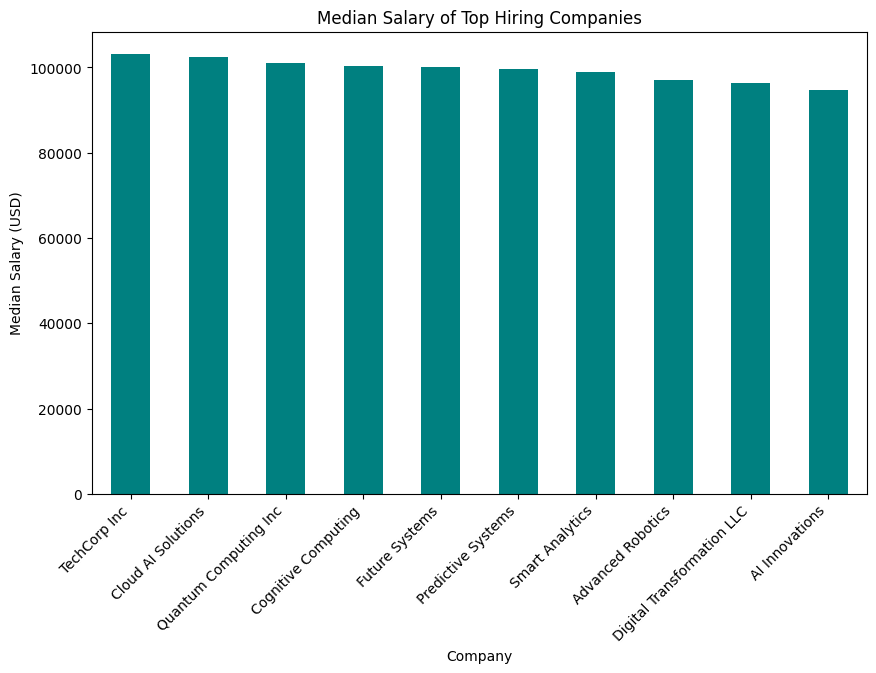

In [9]:

if "company_name" in df.columns:
    top_companies = df["company_name"].value_counts().head(10).index
    comp_df = df[df["company_name"].isin(top_companies)][["company_name","salary_usd"]].dropna()
    comp_salary = comp_df.groupby("company_name")["salary_usd"].median().sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    comp_salary.plot(kind="bar", color="teal")
    plt.title("Median Salary of Top Hiring Companies")
    plt.xlabel("Company")
    plt.ylabel("Median Salary (USD)")
    plt.xticks(rotation=45, ha="right")
    plt.show()


In [10]:

out_path = "ai_job_dataset_cleaned.csv"
cols_to_save = [c for c in ["job_title","company_name","company_location","salary_usd","experience_level","employment_type","remote_ratio","required_skills","industry","posting_date"] if c in df.columns]
df[cols_to_save].to_csv(out_path, index=False)
print("Cleaned dataset saved to:", out_path)


Cleaned dataset saved to: ai_job_dataset_cleaned.csv
